In [6]:
import pyupbit
import numpy as np
import timeit
import queue
from IPython.display import clear_output
from time import sleep
from random import *
import pandas as pd
from matplotlib import pyplot as plt
import mpl_finance

Matplotlib is building the font cache; this may take a moment.
/root/anaconda3/envs/stock/lib/python3.6/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


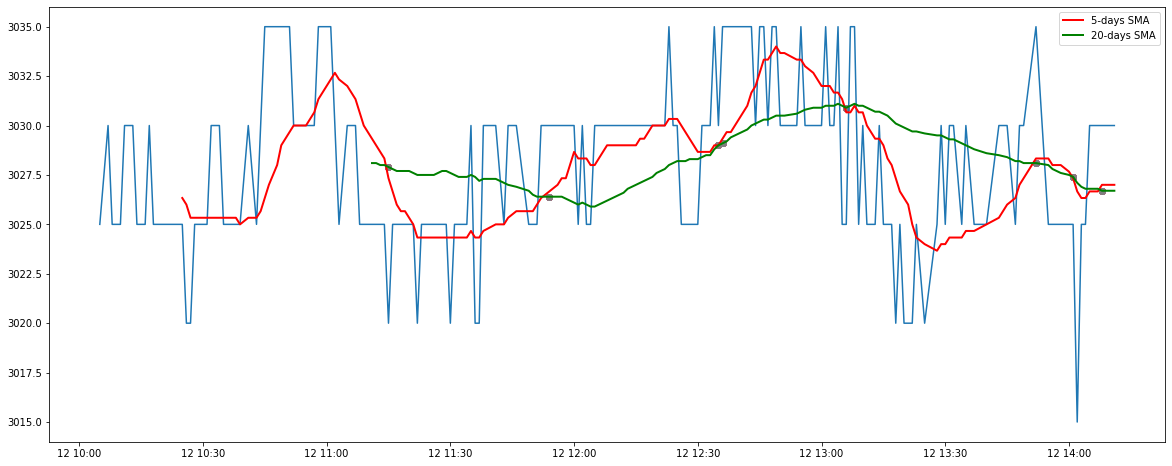

-28.909999999998266


In [7]:
#차트
table_data = pd.DataFrame(pyupbit.get_ohlcv("KRW-EOS", interval="minute1")
                          ,columns=['open', 'high',
                             'low', 'close', 'volume'])

table_data['date'] = table_data.index
table_data= table_data.reset_index()
table_data.drop(['index'],axis='columns',inplace=True)
rolling_5 = table_data.rolling(window=15).mean()
rolling_20 = table_data.rolling(window=50).mean()
rolling_5['date'] = table_data['date']
rolling_20['date'] = table_data['date']

index_nan = 0
for i in range(len(table_data.index)):
    if np.isnan(rolling_20['close'].iloc[i]) == False:
        index_nan = i
        break
        
turnpoint, interval = False, False
first_track = True
idx = []
for i in range(index_nan, len(table_data.index)):
    turnpoint = interval
    if rolling_5['close'].iloc[i] - rolling_20['close'].iloc[i] > 0:
        interval = True
    else:
        interval = False
    if first_track:
        first_track = False
        turnpoint = interval
    if interval != turnpoint:
        idx.append(i)

x = table_data['date']
y = table_data['close']
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
ax.plot(x, y)
ax.plot(x, rolling_5['close'], label= '5-days SMA', linewidth=2, color='red')
ax.plot(x, rolling_20['close'], label = '20-days SMA', linewidth=2, color='green')
for scatter in idx:
    ax.scatter(x[idx],rolling_20['close'].iloc[idx])
plt.legend(loc='best')
plt.show()
Cloud_belt = []
for i in range(len(idx)-1):
    middle_idx = int((idx[i+1]+idx[i])/2)
    Cloud_belt.append([rolling_5['close'].iloc[middle_idx]-
                    rolling_20['close'].iloc[middle_idx],
                     idx[i+1]-idx[i]])
Cloud_belt = pd.DataFrame(Cloud_belt, columns=['depth','Length'])
sum_cloud = 0
for i in range(len(Cloud_belt)):
    sum_cloud+=Cloud_belt.depth.iloc[i]*(0.3*Cloud_belt.Length.iloc[i])

print(sum_cloud)

In [ ]:
빨간선 상승인데 겹치면 매수
5원 비싸게 매도

매수 후에, 빨간 선이 하강하면서 겹치면 매도중인거 전량 취소 후,
현재 시세로 전량 매도

In [416]:
#알고리즘
for i in range(10000):
    clear_output(wait = True)
    #현재 교차점이 있는지 여부 판별
    table_data = pd.DataFrame(pyupbit.get_ohlcv("KRW-EOS", interval="minute1")
                              ,columns=['open', 'high',
                                 'low', 'close', 'volume'])
    table_data['date'] = table_data.index
    table_data= table_data.reset_index()
    table_data.drop(['index'],axis='columns',inplace=True)
    rolling_5 = table_data.rolling(window=15).mean()
    rolling_20 = table_data.rolling(window=50).mean()

    intersection = 0
    turnpoint, interval = False, False
    first_track = True
    for idx in range(len(table_data.index)-2, len(table_data.index)):
        turnpoint = interval
        if rolling_5['close'].iloc[idx] - rolling_20['close'].iloc[idx] > 0:
            interval = True
        else:
            interval = False
        if first_track:
            first_track = False
            turnpoint = interval
        if interval != turnpoint:
            intersection = idx
    print("intersection : {}".format(intersection))

    #빨간선 상승여부 판별
    vals = list(rolling_5['close'].iloc[-5:len(rolling_5)])
    vals.reverse()
    red_determine = 0
    for i in range(4):
        red_determine += vals[i]-vals[i+1]
    print("inclination  : {}".format(red_determine))

    #매수가
    current_price = pyupbit.get_current_price("KRW-EOS")
    buy_price = current_price
    print("buy_price    : {}".format(buy_price))

    #매도가
    sell_price = buy_price+5
    print("sell_price   : {}".format(sell_price))

    #매도가(던지기)
    data = pd.DataFrame(pyupbit.get_orderbook(tickers="KRW-EOS"))
    print("bid_price    : {}".format(data.orderbook_units[0][0]['bid_price']))
    sleep(1)

intersection : 0
inclination  : -3.333333333333485
buy_price    : 3085.0
sell_price   : 3090.0
bid_price    : 3085.0


KeyboardInterrupt: 

In [424]:
#시뮬레이션
current_money = 50000
current_stock = 0
while True :
    clear_output(wait = True)
    #현재 교차점이 있는지 여부 판별
    table_data = pd.DataFrame(pyupbit.get_ohlcv("KRW-EOS", interval="minute1")
                              ,columns=['open', 'high',
                                 'low', 'close', 'volume'])
    table_data['date'] = table_data.index
    table_data= table_data.reset_index()
    table_data.drop(['index'],axis='columns',inplace=True)
    rolling_5 = table_data.rolling(window=15).mean()
    rolling_20 = table_data.rolling(window=50).mean()

    intersection = 0
    turnpoint, interval = False, False
    first_track = True
    for idx in range(len(table_data.index)-2, len(table_data.index)):
        turnpoint = interval
        if rolling_5['close'].iloc[idx] - rolling_20['close'].iloc[idx] > 0:
            interval = True
        else:
            interval = False
        if first_track:
            first_track = False
            turnpoint = interval
        if interval != turnpoint:
            intersection = idx
    print("intersection : {}".format(intersection))

    #빨간선 상승여부 판별
    vals = list(rolling_5['close'].iloc[-5:len(rolling_5)])
    vals.reverse()
    inclination = 0
    for i in range(4):
        inclination += vals[i]-vals[i+1]
    print("inclination  : {}".format(inclination))

    #매수가
    current_price = pyupbit.get_current_price("KRW-EOS")
    buy_price = current_price
    print("buy_price    : {}".format(buy_price))

    #매도가
    sell_price = buy_price+5
    print("sell_price   : {}".format(sell_price))

    #매도가(던지기)
    data = pd.DataFrame(pyupbit.get_orderbook(tickers="KRW-EOS"))
    bid_price = data.orderbook_units[0][0]['bid_price']
    print("bid_price    : {}".format(bid_price))
    
    ###시뮬레이션
    
    #매수
    if inclination > 0 and intersection != 0:
        num_buy_stock  = int(current_money/(buy_price*1.0005))
        current_stock = num_buy_stock
        current_money -= (num_buy_stock*buy_price)*1.0005
        sleep(5)
    if current_stock > 0:
        #매도
        num_sell_stock  = num_buy_stock
        current_stock -= num_sell_stock
        current_money  += (num_sell_stock*sell_price)*0.9995

        #던지기 - 현재 bid_price로 판매되도록 하도록 추가해야 함
        if inclination < 0 and intersection != 0:
            num_sell_stock  = current_stock
            current_stock -= current_stock
            current_money  += (num_sell_stock*bid_price)*0.9995
        
    print("current_money  : {}".format(current_money))
    print("current_stock  : {}".format(current_stock))
    if current_money <0 or current_stock<0:
        print('error')
        break
    sleep(1)

intersection : 0
inclination  : 0.6666666666669698
buy_price    : 3100.0
sell_price   : 3105.0
bid_price    : 3095.0
current_money  : 50000
current_stock  : 0


KeyboardInterrupt: 